# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


In [2]:
alpha = 0.02

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

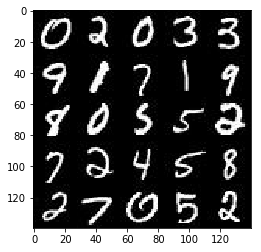

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

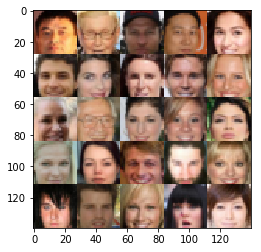

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    img = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_z')
    inputs_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    return img, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
#     print('discriminator')
#     print('images: ', images)
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is ?x28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        relu1 = tf.maximum(0.02 * x1, x1)
        # 14x14x64
#         print(x1)
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.02 * bn2, bn2)
        # 7x7x128
#         print(x2)
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.02 * bn3, bn3)
        # 4x4x256 
#         print(x3)
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
#         print(logits)
        out = tf.sigmoid(logits)
#         print('discriminator out: ', out)
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
#     print('generator')
#     print('out_channel_dim: ', out_channel_dim)
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
#         x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
#         print(x1)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
#         print(x2)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
#         print(x3)

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
#         print(logits)3
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
#     print('Generator for fake images...')
    g_model = generator(input_z, out_channel_dim)
#     print('Passing discriminator with real images...')
    d_model_real, d_logits_real = discriminator(input_real)
#     print('Passing discriminator with fake images...')
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
# tf.reset_default_graph()
show_every=20
print_every=1

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print(epoch_count)
    print(batch_size)
    print(z_dim)
    print(learning_rate)
    print(beta1)
    print(data_shape)
    print(data_image_mode)
    
    

    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, learning_rate_ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print('Starting Session...')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print('Epoch :', epoch_i)
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                
                batch_images = batch_images*2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})

                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)

                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

2
256
30
0.001
0.5
(60000, 28, 28, 1)
L
Starting Session...
Epoch : 0
Epoch 1/2... Discriminator Loss: 3.3020... Generator Loss: 0.0466
Epoch 1/2... Discriminator Loss: 4.6159... Generator Loss: 9.0740
Epoch 1/2... Discriminator Loss: 6.1177... Generator Loss: 0.0035
Epoch 1/2... Discriminator Loss: 0.1113... Generator Loss: 9.5252
Epoch 1/2... Discriminator Loss: 0.3481... Generator Loss: 4.2335
Epoch 1/2... Discriminator Loss: 3.5535... Generator Loss: 0.0510
Epoch 1/2... Discriminator Loss: 3.8407... Generator Loss: 13.7251
Epoch 1/2... Discriminator Loss: 0.1166... Generator Loss: 4.5529
Epoch 1/2... Discriminator Loss: 2.9087... Generator Loss: 0.2041
Epoch 1/2... Discriminator Loss: 0.4441... Generator Loss: 12.9108
Epoch 1/2... Discriminator Loss: 0.6046... Generator Loss: 13.9347
Epoch 1/2... Discriminator Loss: 0.1395... Generator Loss: 11.7490
Epoch 1/2... Discriminator Loss: 0.0356... Generator Loss: 7.7641
Epoch 1/2... Discriminator Loss: 0.2007... Generator Loss: 2.4320
Ep

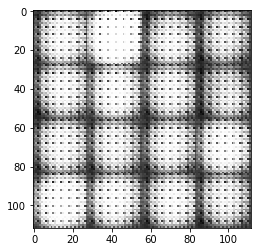

Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 3.5349
Epoch 1/2... Discriminator Loss: 0.4457... Generator Loss: 1.6426
Epoch 1/2... Discriminator Loss: 0.2319... Generator Loss: 2.4024
Epoch 1/2... Discriminator Loss: 0.2639... Generator Loss: 2.6415
Epoch 1/2... Discriminator Loss: 0.2762... Generator Loss: 2.4362
Epoch 1/2... Discriminator Loss: 0.2490... Generator Loss: 3.3696
Epoch 1/2... Discriminator Loss: 0.1862... Generator Loss: 2.9051
Epoch 1/2... Discriminator Loss: 0.1432... Generator Loss: 3.0642
Epoch 1/2... Discriminator Loss: 0.1160... Generator Loss: 3.5178
Epoch 1/2... Discriminator Loss: 0.2090... Generator Loss: 2.4886
Epoch 1/2... Discriminator Loss: 0.4469... Generator Loss: 1.8499
Epoch 1/2... Discriminator Loss: 0.4798... Generator Loss: 6.7726
Epoch 1/2... Discriminator Loss: 0.5922... Generator Loss: 2.3582
Epoch 1/2... Discriminator Loss: 0.0987... Generator Loss: 5.6949
Epoch 1/2... Discriminator Loss: 0.1407... Generator Loss: 4.0548
Epoch 1/2.

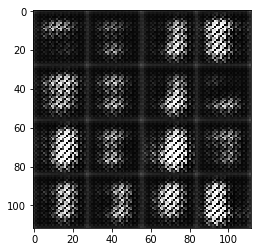

Epoch 1/2... Discriminator Loss: 0.0222... Generator Loss: 5.5399
Epoch 1/2... Discriminator Loss: 2.6529... Generator Loss: 0.2101
Epoch 1/2... Discriminator Loss: 0.1883... Generator Loss: 6.8056
Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 7.1917
Epoch 1/2... Discriminator Loss: 0.4154... Generator Loss: 3.5105
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 1.2026
Epoch 1/2... Discriminator Loss: 0.6128... Generator Loss: 3.8570
Epoch 1/2... Discriminator Loss: 0.6874... Generator Loss: 2.0786
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 1.0518
Epoch 1/2... Discriminator Loss: 0.8810... Generator Loss: 4.8667
Epoch 1/2... Discriminator Loss: 0.3853... Generator Loss: 2.0764
Epoch 1/2... Discriminator Loss: 0.1382... Generator Loss: 2.8152
Epoch 1/2... Discriminator Loss: 0.1064... Generator Loss: 3.7178
Epoch 1/2... Discriminator Loss: 0.1045... Generator Loss: 3.7640
Epoch 1/2... Discriminator Loss: 0.0853... Generator Loss: 3.8893
Epoch 1/2.

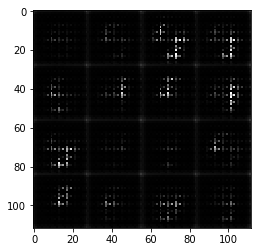

Epoch 1/2... Discriminator Loss: 0.0700... Generator Loss: 3.5581
Epoch 1/2... Discriminator Loss: 0.0488... Generator Loss: 4.7828
Epoch 1/2... Discriminator Loss: 0.0517... Generator Loss: 4.8373
Epoch 1/2... Discriminator Loss: 0.0379... Generator Loss: 4.6591
Epoch 1/2... Discriminator Loss: 0.0280... Generator Loss: 5.0325
Epoch 1/2... Discriminator Loss: 0.0206... Generator Loss: 5.4950
Epoch 1/2... Discriminator Loss: 0.0116... Generator Loss: 5.7959
Epoch 1/2... Discriminator Loss: 0.0131... Generator Loss: 5.9394
Epoch 1/2... Discriminator Loss: 0.0127... Generator Loss: 5.9572
Epoch 1/2... Discriminator Loss: 0.0115... Generator Loss: 5.6238
Epoch 1/2... Discriminator Loss: 0.0797... Generator Loss: 2.6877
Epoch 1/2... Discriminator Loss: 0.0200... Generator Loss: 7.6860
Epoch 1/2... Discriminator Loss: 0.0205... Generator Loss: 7.8717
Epoch 1/2... Discriminator Loss: 0.0473... Generator Loss: 4.0619
Epoch 1/2... Discriminator Loss: 0.6509... Generator Loss: 1.1557
Epoch 1/2.

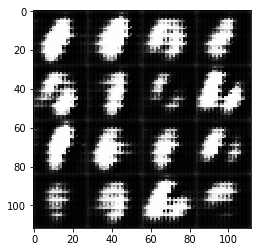

Epoch 1/2... Discriminator Loss: 0.3740... Generator Loss: 2.0341
Epoch 1/2... Discriminator Loss: 0.1859... Generator Loss: 3.2152
Epoch 1/2... Discriminator Loss: 0.1592... Generator Loss: 3.1240
Epoch 1/2... Discriminator Loss: 0.1792... Generator Loss: 2.6671
Epoch 1/2... Discriminator Loss: 0.2097... Generator Loss: 2.4291
Epoch 1/2... Discriminator Loss: 0.1831... Generator Loss: 2.5558
Epoch 1/2... Discriminator Loss: 0.2028... Generator Loss: 2.5367
Epoch 1/2... Discriminator Loss: 0.1667... Generator Loss: 2.6072
Epoch 1/2... Discriminator Loss: 0.2372... Generator Loss: 2.1171
Epoch 1/2... Discriminator Loss: 0.3401... Generator Loss: 1.6659
Epoch 1/2... Discriminator Loss: 0.6946... Generator Loss: 1.3285
Epoch 1/2... Discriminator Loss: 0.8671... Generator Loss: 1.4705
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 2.2369
Epoch 1/2... Discriminator Loss: 0.6756... Generator Loss: 1.5433
Epoch 1/2... Discriminator Loss: 0.5527... Generator Loss: 2.4222
Epoch 1/2.

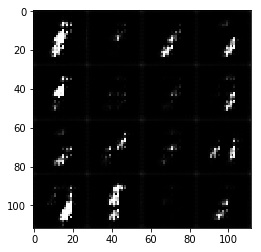

Epoch 1/2... Discriminator Loss: 0.6819... Generator Loss: 1.6444
Epoch 1/2... Discriminator Loss: 0.6461... Generator Loss: 2.7425
Epoch 1/2... Discriminator Loss: 0.8463... Generator Loss: 1.5887
Epoch 1/2... Discriminator Loss: 0.9968... Generator Loss: 1.3143
Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 1.6059
Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 1.3925
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 1.2570
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 1.6755
Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 1.5593
Epoch 1/2... Discriminator Loss: 0.5750... Generator Loss: 2.0777
Epoch 1/2... Discriminator Loss: 0.5550... Generator Loss: 1.8461
Epoch 1/2... Discriminator Loss: 0.5812... Generator Loss: 1.5043
Epoch 1/2... Discriminator Loss: 0.8643... Generator Loss: 2.2207
Epoch 1/2... Discriminator Loss: 1.2791... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 2.7605... Generator Loss: 5.3152
Epoch 1/2.

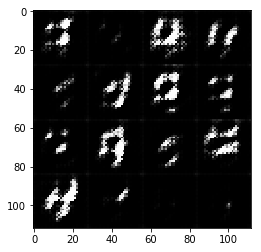

Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 1.1394
Epoch 1/2... Discriminator Loss: 0.8544... Generator Loss: 1.1391
Epoch 1/2... Discriminator Loss: 1.0399... Generator Loss: 1.6826
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 1.2698
Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 1.4766
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 0.9170
Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 2.6835
Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 0.5588
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 3.5889
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 0.7103
Epoch 1/2... Discriminator Loss: 0.7977... Generator Loss: 2.0060
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 1.0252
Epoch 1/2... Discriminator Loss: 0.8529... Generator Loss: 2.1366
Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 0.7952
Epoch 1/2... Discriminator Loss: 1.4146... Generator Loss: 3.1724
Epoch 1/2.

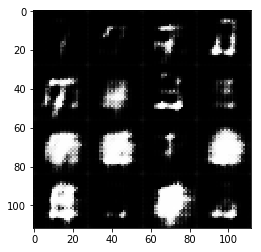

Epoch 1/2... Discriminator Loss: 0.8539... Generator Loss: 1.0697
Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 1.0234
Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 1.5216
Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 0.6428
Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 3.6048
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 0.9712
Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 1.6598
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 1.4681
Epoch 1/2... Discriminator Loss: 1.0197... Generator Loss: 0.9833
Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 1.9313
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 0.5910
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 4.3496
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 0.7496
Epoch 1/2... Discriminator Loss: 0.8727... Generator Loss: 1.6743
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 1.1562
Epoch 1/2.

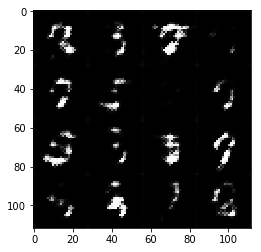

Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 0.6336
Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 1.0164
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 1.8459
Epoch 1/2... Discriminator Loss: 1.1372... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 0.9894... Generator Loss: 1.8009
Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 1.1708
Epoch 1/2... Discriminator Loss: 0.9687... Generator Loss: 1.5222
Epoch 1/2... Discriminator Loss: 1.1441... Generator Loss: 0.6132
Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 2.8225
Epoch 1/2... Discriminator Loss: 1.4318... Generator Loss: 0.4081
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 2.1115
Epoch 1/2... Discriminator Loss: 1.2657... Generator Loss: 0.6579
Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 1.7561
Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 1.0637
Epoch 1/2.

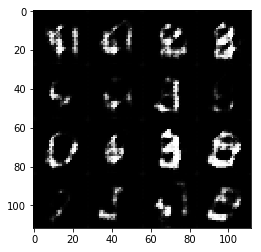

Epoch 1/2... Discriminator Loss: 0.9631... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 1.4547
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 0.9890
Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 1.4051
Epoch 1/2... Discriminator Loss: 0.7498... Generator Loss: 1.3785
Epoch 1/2... Discriminator Loss: 0.6861... Generator Loss: 1.4696
Epoch 1/2... Discriminator Loss: 0.5753... Generator Loss: 1.6829
Epoch 1/2... Discriminator Loss: 0.6717... Generator Loss: 1.5107
Epoch 1/2... Discriminator Loss: 0.8217... Generator Loss: 1.5281
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 2.6818... Generator Loss: 4.1134
Epoch 1/2... Discriminator Loss: 3.8503... Generator Loss: 0.0399
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 1.7804
Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 1.9837
Epoch 1/2... Discriminator Loss: 1.3506... Generator Loss: 0.4708
Epoch 1/2.

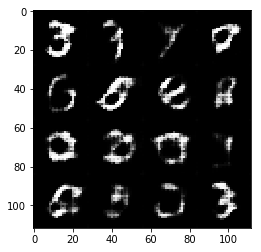

Epoch 1/2... Discriminator Loss: 1.0476... Generator Loss: 1.2417
Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 1.0015
Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 1.0989
Epoch 1/2... Discriminator Loss: 1.1404... Generator Loss: 0.9211
Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 1.1769
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 0.9327
Epoch 1/2... Discriminator Loss: 1.1295... Generator Loss: 0.9664
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 0.8847
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 1.4002
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 0.8985
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 1.6294
Epoch 1/2... Discriminator Loss: 1.2891... Generator Loss: 0.6149
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 1.8322
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.5390
Epoch 1/2.

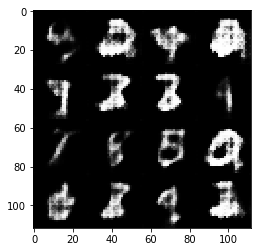

Epoch 1/2... Discriminator Loss: 1.2602... Generator Loss: 0.7344
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 1.1445
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 1.3330
Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 0.5822
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 1.3350
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 0.5864
Epoch 1/2... Discriminator Loss: 1.1436... Generator Loss: 1.4463
Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 0.8574
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 1.1778
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 0.6451
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 1.5492
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.4667
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 1.8656
Epoch : 1
Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 0.6409


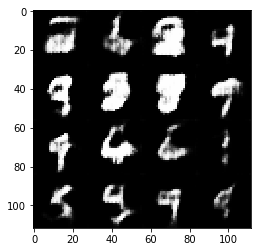

Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.9113
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 1.0692
Epoch 2/2... Discriminator Loss: 1.2261... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 1.0889... Generator Loss: 1.3798
Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 0.7694
Epoch 2/2... Discriminator Loss: 1.0689... Generator Loss: 1.5613
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 1.4967... Generator Loss: 1.3641
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.6633
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 1.4098
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.8735
Epoch 2/2... Discriminator Loss: 1.1739... Generator Loss: 0.8241
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.9273
Epoch 2/2... Discriminator Loss: 1.2583... Generator Loss: 0.9043
Epoch 2/2... Discriminator Loss: 1.1206... Generator Loss: 0.9305
Epoch 2/2.

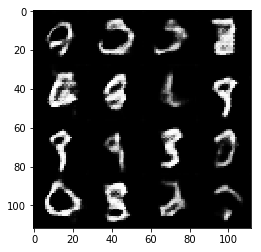

Epoch 2/2... Discriminator Loss: 1.1152... Generator Loss: 0.8068
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 1.5690
Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 0.5686
Epoch 2/2... Discriminator Loss: 1.5519... Generator Loss: 1.5514
Epoch 2/2... Discriminator Loss: 1.4838... Generator Loss: 0.4522
Epoch 2/2... Discriminator Loss: 1.4089... Generator Loss: 1.5409
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 0.5754
Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 1.2307
Epoch 2/2... Discriminator Loss: 1.0278... Generator Loss: 0.9124
Epoch 2/2... Discriminator Loss: 1.0966... Generator Loss: 0.8497
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 1.0196
Epoch 2/2... Discriminator Loss: 1.1653... Generator Loss: 0.7642
Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 1.2969
Epoch 2/2... Discriminator Loss: 1.1180... Generator Loss: 0.7437
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 1.0041
Epoch 2/2.

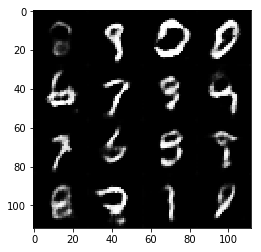

Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.6756
Epoch 2/2... Discriminator Loss: 1.1520... Generator Loss: 1.5033
Epoch 2/2... Discriminator Loss: 1.0257... Generator Loss: 0.7146
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 1.2528
Epoch 2/2... Discriminator Loss: 1.1840... Generator Loss: 0.8511
Epoch 2/2... Discriminator Loss: 1.1095... Generator Loss: 0.9281
Epoch 2/2... Discriminator Loss: 1.1514... Generator Loss: 1.0383
Epoch 2/2... Discriminator Loss: 1.1967... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 1.2667
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 0.5778
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 1.6436
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 1.2604... Generator Loss: 1.7621
Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 0.5362
Epoch 2/2... Discriminator Loss: 1.1364... Generator Loss: 1.5017
Epoch 2/2.

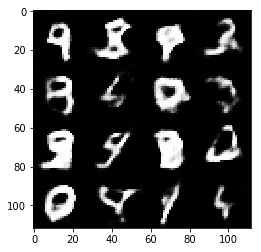

Epoch 2/2... Discriminator Loss: 1.1322... Generator Loss: 1.1354
Epoch 2/2... Discriminator Loss: 1.1081... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.2555
Epoch 2/2... Discriminator Loss: 1.0816... Generator Loss: 0.7393
Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 1.6423
Epoch 2/2... Discriminator Loss: 1.4862... Generator Loss: 0.4099
Epoch 2/2... Discriminator Loss: 1.4686... Generator Loss: 2.0173
Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.4467
Epoch 2/2... Discriminator Loss: 1.2921... Generator Loss: 1.7823
Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 0.5617
Epoch 2/2... Discriminator Loss: 1.1274... Generator Loss: 1.3021
Epoch 2/2... Discriminator Loss: 1.0694... Generator Loss: 0.9527
Epoch 2/2... Discriminator Loss: 0.9874... Generator Loss: 1.0827
Epoch 2/2... Discriminator Loss: 1.0401... Generator Loss: 1.0644
Epoch 2/2... Discriminator Loss: 1.1290... Generator Loss: 0.8363
Epoch 2/2.

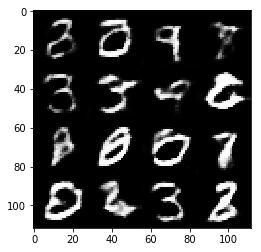

Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.6171
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 1.5229
Epoch 2/2... Discriminator Loss: 1.0825... Generator Loss: 0.7512
Epoch 2/2... Discriminator Loss: 1.0315... Generator Loss: 1.2699
Epoch 2/2... Discriminator Loss: 1.0838... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 1.3574
Epoch 2/2... Discriminator Loss: 1.2350... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 1.2308... Generator Loss: 1.5533
Epoch 2/2... Discriminator Loss: 1.2728... Generator Loss: 0.5129
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 1.5003
Epoch 2/2... Discriminator Loss: 1.2453... Generator Loss: 0.5950
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 1.6476
Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.0779... Generator Loss: 1.4401
Epoch 2/2... Discriminator Loss: 1.1108... Generator Loss: 0.8227
Epoch 2/2.

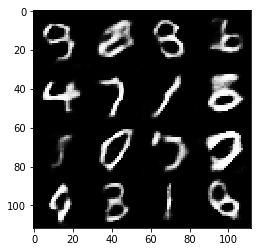

Epoch 2/2... Discriminator Loss: 1.3385... Generator Loss: 1.5010
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 0.4138
Epoch 2/2... Discriminator Loss: 1.4628... Generator Loss: 1.8283
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.5015
Epoch 2/2... Discriminator Loss: 1.1450... Generator Loss: 1.5394
Epoch 2/2... Discriminator Loss: 1.0102... Generator Loss: 0.8117
Epoch 2/2... Discriminator Loss: 0.9615... Generator Loss: 0.9950
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 1.2184
Epoch 2/2... Discriminator Loss: 1.1316... Generator Loss: 0.8257
Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 1.1293
Epoch 2/2... Discriminator Loss: 1.2128... Generator Loss: 0.6144
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 1.7046
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 0.5909
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 1.6707
Epoch 2/2... Discriminator Loss: 1.0691... Generator Loss: 0.6749
Epoch 2/2.

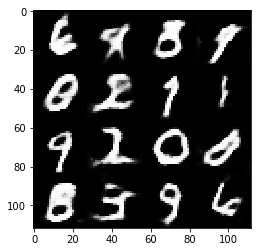

Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 1.0356
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 0.9129
Epoch 2/2... Discriminator Loss: 0.9214... Generator Loss: 1.3978
Epoch 2/2... Discriminator Loss: 1.1440... Generator Loss: 0.6070
Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 1.9178
Epoch 2/2... Discriminator Loss: 1.5219... Generator Loss: 0.3633
Epoch 2/2... Discriminator Loss: 1.5610... Generator Loss: 1.7861
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 0.6027
Epoch 2/2... Discriminator Loss: 1.0578... Generator Loss: 1.6167
Epoch 2/2... Discriminator Loss: 0.9067... Generator Loss: 0.8082
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 1.1450
Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.9962
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 1.1746
Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 1.0083
Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 1.4998
Epoch 2/2.

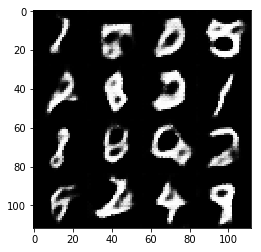

Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 1.4081
Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 0.6633
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 1.6850
Epoch 2/2... Discriminator Loss: 1.2708... Generator Loss: 0.5006
Epoch 2/2... Discriminator Loss: 1.3201... Generator Loss: 1.8376
Epoch 2/2... Discriminator Loss: 1.3887... Generator Loss: 0.4312
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 1.6383
Epoch 2/2... Discriminator Loss: 1.2261... Generator Loss: 0.6261
Epoch 2/2... Discriminator Loss: 1.1180... Generator Loss: 1.3351
Epoch 2/2... Discriminator Loss: 1.1417... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 1.3924
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 1.5897
Epoch 2/2... Discriminator Loss: 1.4778... Generator Loss: 0.3578
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 1.9101
Epoch 2/2.

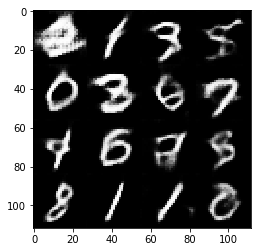

Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 0.8350
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 1.3206
Epoch 2/2... Discriminator Loss: 1.5689... Generator Loss: 0.3418
Epoch 2/2... Discriminator Loss: 1.5514... Generator Loss: 1.9814
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 0.5532
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 1.0904
Epoch 2/2... Discriminator Loss: 1.1793... Generator Loss: 0.9642
Epoch 2/2... Discriminator Loss: 1.2039... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 1.1431... Generator Loss: 0.9997
Epoch 2/2... Discriminator Loss: 1.0955... Generator Loss: 0.9182
Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 0.9698
Epoch 2/2... Discriminator Loss: 1.1426... Generator Loss: 0.8757
Epoch 2/2... Discriminator Loss: 1.1598... Generator Loss: 0.9212
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 0.9836
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 0.8083
Epoch 2/2.

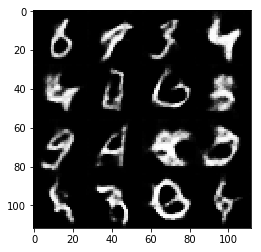

Epoch 2/2... Discriminator Loss: 1.3255... Generator Loss: 1.6965
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.4883
Epoch 2/2... Discriminator Loss: 1.3072... Generator Loss: 1.3640
Epoch 2/2... Discriminator Loss: 1.2298... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.1397... Generator Loss: 1.3268
Epoch 2/2... Discriminator Loss: 1.0623... Generator Loss: 0.7709
Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 1.2351
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 1.3413... Generator Loss: 1.1373
Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 0.5296
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 1.5485
Epoch 2/2... Discriminator Loss: 1.1950... Generator Loss: 0.5542
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 1.6742
Epoch 2/2... Discriminator Loss: 1.1475... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 1.1898
Epoch 2/2.

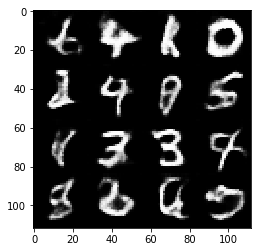

Epoch 2/2... Discriminator Loss: 1.2597... Generator Loss: 1.4874
Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 0.4430
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 1.7268
Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 0.5136
Epoch 2/2... Discriminator Loss: 1.1626... Generator Loss: 1.4809
Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 0.5252
Epoch 2/2... Discriminator Loss: 1.2679... Generator Loss: 1.3379
Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 0.7023
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 1.1786
Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 0.9484
Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 0.8378
Epoch 2/2... Discriminator Loss: 1.2350... Generator Loss: 1.0128
Epoch 2/2... Discriminator Loss: 1.1480... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 1.1982
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 0.8413
Epoch 2/2.

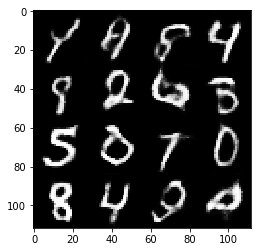

Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 0.7595
Epoch 2/2... Discriminator Loss: 1.2352... Generator Loss: 1.3518
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 0.4200
Epoch 2/2... Discriminator Loss: 1.7234... Generator Loss: 2.2109
Epoch 2/2... Discriminator Loss: 1.5002... Generator Loss: 0.3550
Epoch 2/2... Discriminator Loss: 1.2629... Generator Loss: 1.5635
Epoch 2/2... Discriminator Loss: 1.1714... Generator Loss: 0.6943
Epoch 2/2... Discriminator Loss: 1.2205... Generator Loss: 0.9657


In [13]:
batch_size = 256
z_dim = 30
learning_rate = 0.001
beta1 = 0.5
tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

1
128
100
0.001
0.5
(202599, 28, 28, 3)
RGB
Starting Session...
Epoch : 0
Epoch 1/1... Discriminator Loss: 14.5924... Generator Loss: 0.0000
Epoch 1/1... Discriminator Loss: 6.3558... Generator Loss: 0.0020
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 5.3335
Epoch 1/1... Discriminator Loss: 3.1278... Generator Loss: 0.0561
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 11.5896
Epoch 1/1... Discriminator Loss: 0.1711... Generator Loss: 4.7138
Epoch 1/1... Discriminator Loss: 4.9564... Generator Loss: 0.0085
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 13.2582
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 11.2189
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 0.2868... Generator Loss: 8.7854
Epoch 1/1... Discriminator Loss: 0.4293... Generator Loss: 2.8205
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 8.942

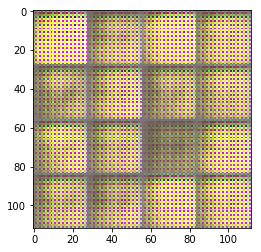

Epoch 1/1... Discriminator Loss: 0.1109... Generator Loss: 6.0966
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 2.8787
Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 2.0791
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.9951
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 6.8787
Epoch 1/1... Discriminator Loss: 4.8124... Generator Loss: 0.0538
Epoch 1/1... Discriminator Loss: 2.9389... Generator Loss: 7.2482
Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 3.0318
Epoch 1/1... Discriminator Loss: 2.4628... Generator Loss: 0.3958
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 2.7026
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 2.4318
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 2.1379
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 2.2977
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 0.9327
Epoch 1/1.

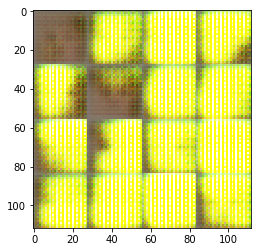

Epoch 1/1... Discriminator Loss: 0.2821... Generator Loss: 2.3551
Epoch 1/1... Discriminator Loss: 0.2502... Generator Loss: 4.0144
Epoch 1/1... Discriminator Loss: 0.1828... Generator Loss: 3.7729
Epoch 1/1... Discriminator Loss: 0.2054... Generator Loss: 2.3048
Epoch 1/1... Discriminator Loss: 0.3499... Generator Loss: 1.5098
Epoch 1/1... Discriminator Loss: 0.2043... Generator Loss: 2.8289
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 1.9864
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 4.2403
Epoch 1/1... Discriminator Loss: 1.6250... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 4.5183
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 2.8474
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.1440
Epoch 1/1.

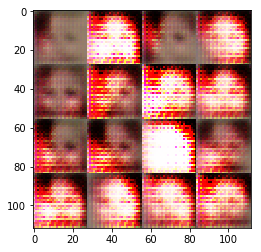

Epoch 1/1... Discriminator Loss: 2.6342... Generator Loss: 5.3194
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 2.1870
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.3842
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 1.5828
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 1.2276
Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 1.5961
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 2.3773
Epoch 1/1... Discriminator Loss: 2.5848... Generator Loss: 0.1742
Epoch 1/1... Discriminator Loss: 2.0545... Generator Loss: 3.8457
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.3930
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 2.2416
Epoch 1/1.

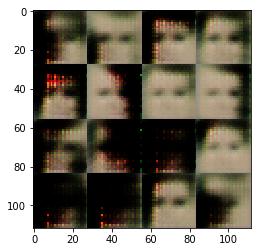

Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 4.1582
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 1.5296
Epoch 1/1... Discriminator Loss: 1.8191... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: 1.9012... Generator Loss: 3.0111
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.8280... Generator Loss: 1.6977
Epoch 1/1... Discriminator Loss: 1.8326... Generator Loss: 0.2765
Epoch 1/1.

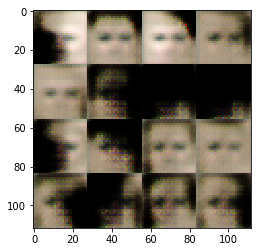

Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 2.0573
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 1.9093
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.4334
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 1.6850
Epoch 1/1... Discriminator Loss: 1.7965... Generator Loss: 0.4090
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 1.1540
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.8104
Epoch 1/1.

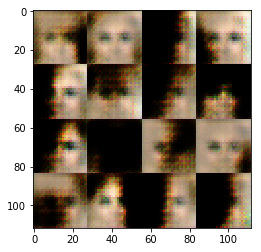

Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 1.6832
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.1942
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.3764
Epoch 1/1... Discriminator Loss: 1.6852... Generator Loss: 1.9186
Epoch 1/1... Discriminator Loss: 1.7905... Generator Loss: 0.3460
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 0.7141... Generator Loss: 1.5319
Epoch 1/1.

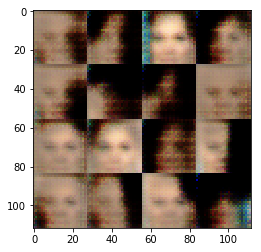

Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.6155... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 1.6013
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 2.1657
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.2673
Epoch 1/1.

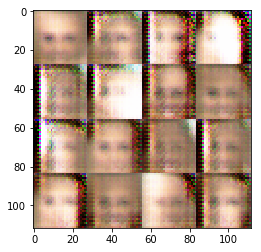

Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.5988
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 1.5755
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.5340
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 1.5398
Epoch 1/1... Discriminator Loss: 2.4664... Generator Loss: 0.1463
Epoch 1/1... Discriminator Loss: 5.9560... Generator Loss: 6.8315
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 2.0576
Epoch 1/1... Discriminator Loss: 3.1844... Generator Loss: 0.0665
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.4209
Epoch 1/1... Discriminator Loss: 1.7231... Generator Loss: 2.1578
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 1.7662... Generator Loss: 0.4614
Epoch 1/1.

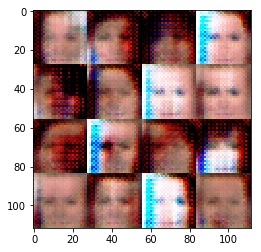

Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.1833
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.7926... Generator Loss: 0.4747
Epoch 1/1.

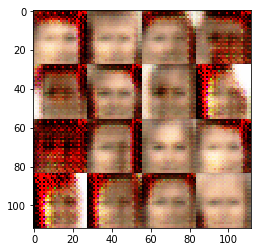

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.5069
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.7464... Generator Loss: 1.7691
Epoch 1/1... Discriminator Loss: 1.9444... Generator Loss: 0.2385
Epoch 1/1... Discriminator Loss: 1.7002... Generator Loss: 2.4950
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 1.4871
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.5849
Epoch 1/1.

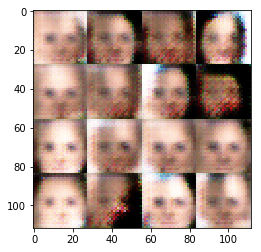

Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 0.8662... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 1.1299
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.5035
Epoch 1/1... Discriminator Loss: 2.4022... Generator Loss: 2.8940
Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.3529
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.8204
Epoch 1/1.

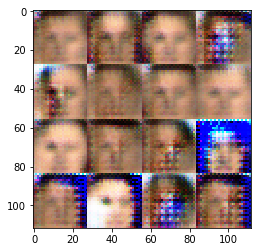

Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 1.8364... Generator Loss: 0.2553
Epoch 1/1... Discriminator Loss: 3.1073... Generator Loss: 3.4616
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.9196... Generator Loss: 0.2311
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.6319
Epoch 1/1.

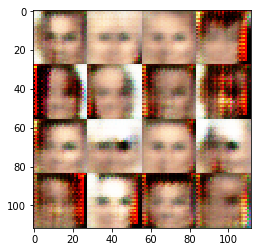

Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.9716
Epoch 1/1... Discriminator Loss: 1.7001... Generator Loss: 0.3047
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 2.4758
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 1.8895
Epoch 1/1.

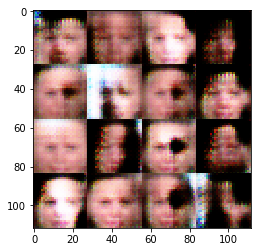

Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 1.6296
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.9547
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 1.7612... Generator Loss: 0.3330
Epoch 1/1... Discriminator Loss: 1.9542... Generator Loss: 2.2054
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 1.2331
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 0.7711
Epoch 1/1.

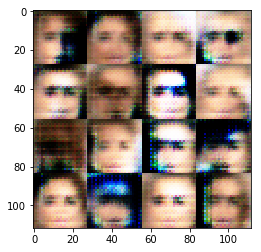

Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.3858
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.4430
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 1.4589
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.6526... Generator Loss: 1.6512
Epoch 1/1... Discriminator Loss: 1.9378... Generator Loss: 0.2484
Epoch 1/1... Discriminator Loss: 1.7688... Generator Loss: 2.2600
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 1.4535
Epoch 1/1.

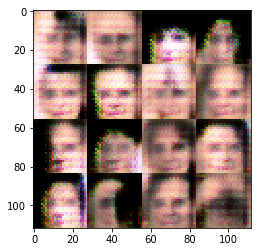

Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 1.3995
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 2.1242
Epoch 1/1... Discriminator Loss: 1.9553... Generator Loss: 0.2342
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 2.1839
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 2.3795... Generator Loss: 0.1957
Epoch 1/1... Discriminator Loss: 1.8227... Generator Loss: 2.7623
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.7957
Epoch 1/1.

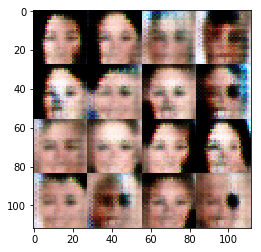

Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 1.9210
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 2.8588
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 2.8464
Epoch 1/1... Discriminator Loss: 1.6806... Generator Loss: 0.3295
Epoch 1/1... Discriminator Loss: 2.0457... Generator Loss: 3.2775
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 0.8840
Epoch 1/1.

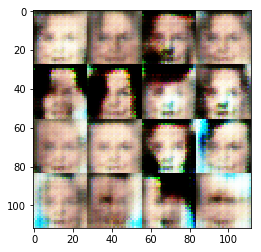

Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.3776
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 2.0156
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.3820
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.6165... Generator Loss: 0.3770
Epoch 1/1... Discriminator Loss: 1.9237... Generator Loss: 2.7176
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.5891
Epoch 1/1.

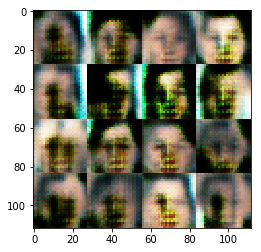

Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 1.6944... Generator Loss: 2.7657
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 2.2755
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.4823
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 2.8986... Generator Loss: 4.2573
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.4217
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.6825
Epoch 1/1.

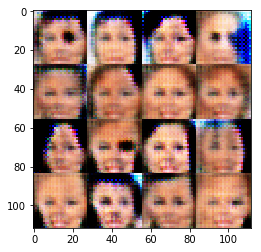

Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.4029
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.4838
Epoch 1/1... Discriminator Loss: 1.6088... Generator Loss: 0.3750
Epoch 1/1... Discriminator Loss: 1.6415... Generator Loss: 3.1832
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.6850
Epoch 1/1.

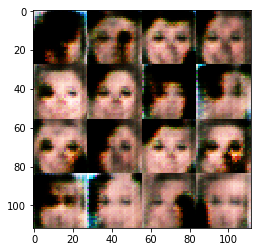

Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 2.1644
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 2.7334
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 2.2963... Generator Loss: 0.1468
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 2.1355
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 1.8271
Epoch 1/1.

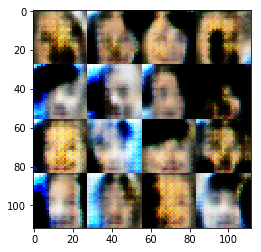

Epoch 1/1... Discriminator Loss: 1.7343... Generator Loss: 0.3188
Epoch 1/1... Discriminator Loss: 2.3153... Generator Loss: 4.1105
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 2.4332
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.7929... Generator Loss: 0.3296
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 2.1930
Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 1.6692
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.5393
Epoch 1/1.

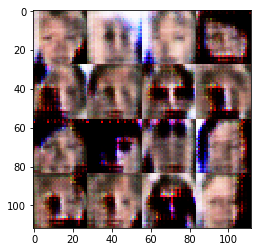

Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 1.7089
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.2141
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.3463
Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 1.2992
Epoch 1/1... Discriminator Loss: 2.3823... Generator Loss: 0.2131
Epoch 1/1... Discriminator Loss: 3.1620... Generator Loss: 3.6849
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 1.7596
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.3358
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 2.0469
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 1.9389
Epoch 1/1... Discriminator Loss: 0.4462... Generator Loss: 1.3357
Epoch 1/1.

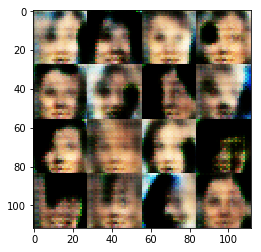

Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.2709
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.6388
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.7308... Generator Loss: 0.3731
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 2.2093
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.2999
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.9529
Epoch 1/1.

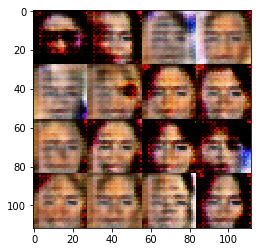

Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 2.4937
Epoch 1/1... Discriminator Loss: 0.7223... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.4082
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 1.5523
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.4142
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 1.4428
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 1.6712
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.9200
Epoch 1/1.

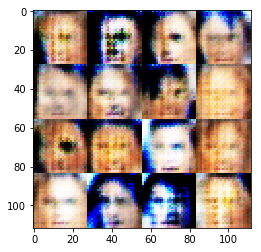

Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 0.7986... Generator Loss: 1.6499
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.6371
Epoch 1/1... Discriminator Loss: 1.6708... Generator Loss: 0.3178
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 2.4422
Epoch 1/1... Discriminator Loss: 1.5776... Generator Loss: 0.3665
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 2.2626
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.5255
Epoch 1/1.

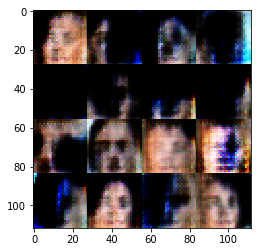

Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.9590
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 0.5482... Generator Loss: 1.5622
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 1.7845
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.3134
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 3.0765
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.6015
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.6187
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.2787
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 0.9058
Epoch 1/1.

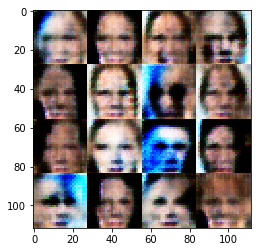

Epoch 1/1... Discriminator Loss: 2.2557... Generator Loss: 0.1526
Epoch 1/1... Discriminator Loss: 2.6660... Generator Loss: 3.0240
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 1.7002
Epoch 1/1... Discriminator Loss: 1.7060... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.5033
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 1.7252... Generator Loss: 2.2751
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 1.9411
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.5986
Epoch 1/1.

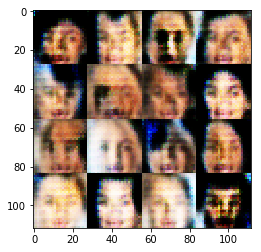

Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.2922
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 2.0995... Generator Loss: 0.1761
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 2.3511
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.9937
Epoch 1/1... Discriminator Loss: 0.4729... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 0.7624
Epoch 1/1.

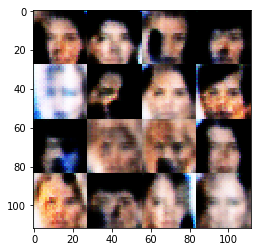

Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.6464
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 1.4035
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 2.1482
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.6086
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 1.1790
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 2.4025
Epoch 1/1... Discriminator Loss: 1.7255... Generator Loss: 0.2939
Epoch 1/1... Discriminator Loss: 2.1454... Generator Loss: 1.6311
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.7867
Epoch 1/1.

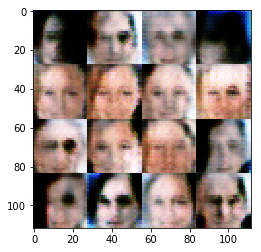

Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 1.5964
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.3424
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.3683
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 1.6788... Generator Loss: 0.3998
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.6796... Generator Loss: 1.5194
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.2193
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7123
Epoch 1/1.

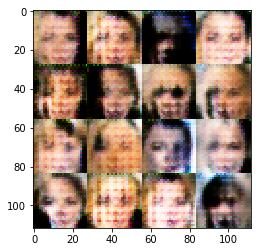

Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.6670... Generator Loss: 2.8124
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.7332... Generator Loss: 0.2837
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.2896
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 1.2335
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.4224
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 1.4968
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.7245
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 1.0798
Epoch 1/1.

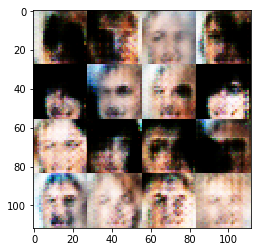

Epoch 1/1... Discriminator Loss: 1.7654... Generator Loss: 0.3012
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.4920
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.5350
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.4459
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.2041
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 1.5646
Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 1.8698
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.0154
Epoch 1/1.

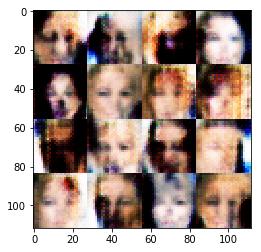

Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 1.2865
Epoch 1/1... Discriminator Loss: 1.5946... Generator Loss: 0.3758
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.3230
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 0.9191... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 2.2118
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 1.5209
Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 0.3516
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.4787
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 2.5489
Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 1.3080
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 0.9560
Epoch 1/1.

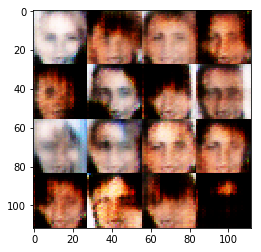

Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 2.6120
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 1.7244... Generator Loss: 0.3311
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 1.8317
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.7854
Epoch 1/1.

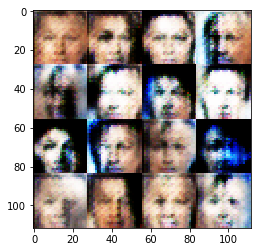

Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.6955... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 2.1779
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 1.5608... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.4070
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 2.0691... Generator Loss: 2.6558
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.5115
Epoch 1/1.

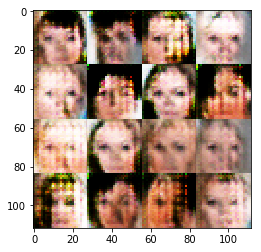

Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 1.4041
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.4405
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.4045
Epoch 1/1... Discriminator Loss: 0.7483... Generator Loss: 1.5662
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.9331
Epoch 1/1.

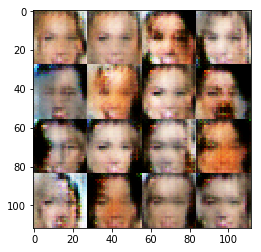

Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 1.6538
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.4454
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 1.2297
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.7686
Epoch 1/1.

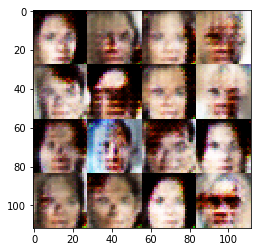

Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 1.5034
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.3695
Epoch 1/1.

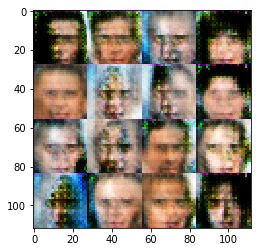

Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 1.9833
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 1.3687
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 1.6196
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 1.0077
Epoch 1/1.

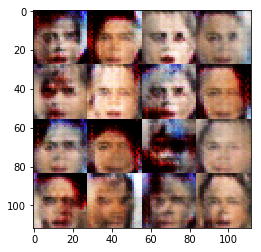

Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 2.2435
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 2.0229... Generator Loss: 0.3223
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 1.6015
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 1.8225... Generator Loss: 0.2744
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 1.5453
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 1.4329
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.4047
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 1.9093
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 1.4512
Epoch 1/1... Discriminator Loss: 0.7366... Generator Loss: 0.9780
Epoch 1/1.

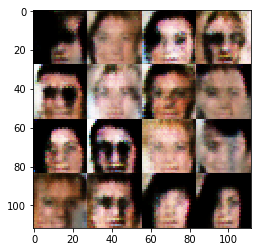

Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 1.4900
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 1.1134
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 1.6967
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 1.5509
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.4418
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.4525
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 2.3921
Epoch 1/1.

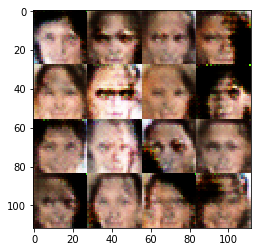

Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 1.1611
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.5171
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.3285
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 0.9852
Epoch 1/1.

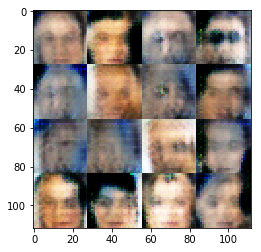

Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.7053... Generator Loss: 2.2761
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.5988
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.4438
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 1.6370
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 1.6216
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.8349
Epoch 1/1.

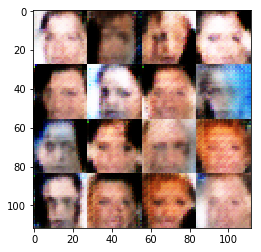

Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.3444
Epoch 1/1... Discriminator Loss: 1.8896... Generator Loss: 0.2043
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 1.2932
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7908
Epoch 1/1.

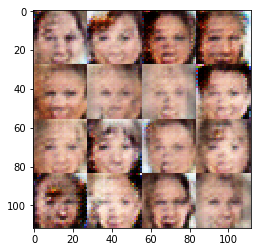

Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.1807
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.3388
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.3586
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.6290
Epoch 1/1.

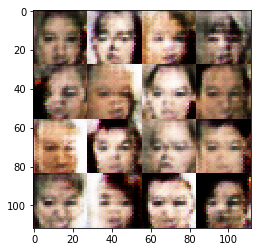

Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.2687
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.6885... Generator Loss: 0.3214
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 2.1574
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.3702
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.8632... Generator Loss: 2.5632
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.8985... Generator Loss: 0.2647
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 1.5571
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 1.1656
Epoch 1/1.

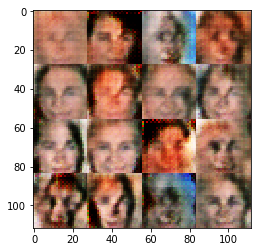

Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 0.6656... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.2388
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 1.2648
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.5287
Epoch 1/1.

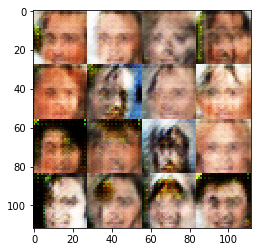

Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 1.6651
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.9356
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 1.2848
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.2046
Epoch 1/1.

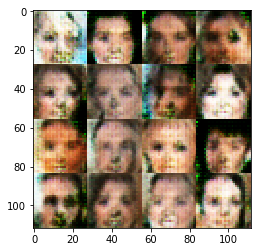

Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.3854
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 2.3345
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.5657
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 2.0146... Generator Loss: 0.2226
Epoch 1/1... Discriminator Loss: 1.6169... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 2.5120
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.5682
Epoch 1/1.

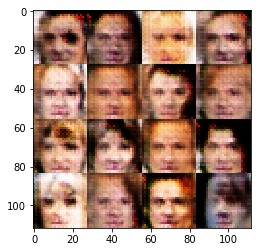

Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.2280
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 0.7409
Epoch 1/1.

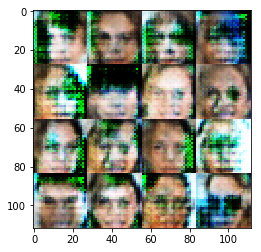

Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.6888
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 1.5690... Generator Loss: 0.3989
Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 2.0959
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 1.6618
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 0.8688
Epoch 1/1.

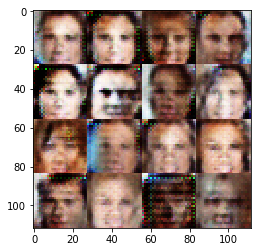

Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 1.1544
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.8715
Epoch 1/1.

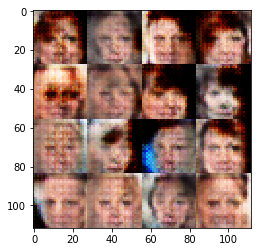

Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 1.8736
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 1.6201
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.6247
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 1.3707
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.4763
Epoch 1/1.

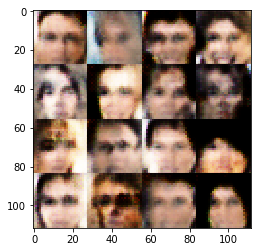

Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.6888... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.4720
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.6533... Generator Loss: 1.4754
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.1777
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.0599
Epoch 1/1.

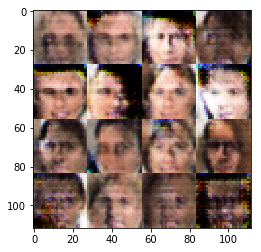

Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.7039... Generator Loss: 2.1522
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.5548
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.6352... Generator Loss: 1.6041
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 0.7382
Epoch 1/1.

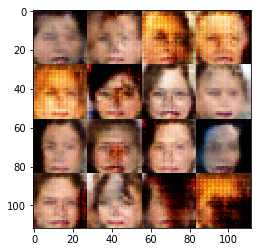

Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 1.4716
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 1.6062
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.3947
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.3670
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.8427
Epoch 1/1.

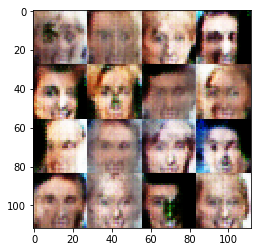

Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.6059
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 1.7462
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 1.4143
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.6508
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.4055
Epoch 1/1... Discriminator Loss: 2.5340... Generator Loss: 2.6849
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 0.8216
Epoch 1/1.

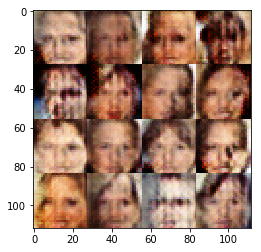

Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 1.5060
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.4679
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 1.4132
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 1.8145
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.4062
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 1.5705
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.8198
Epoch 1/1.

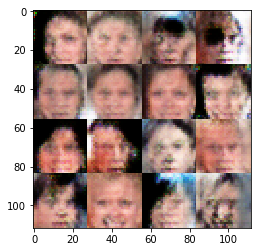

Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 1.7457
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.5646
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 1.6264
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.3065
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.6395
Epoch 1/1.

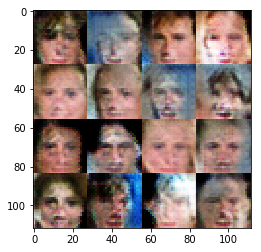

Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 1.6164
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.7003
Epoch 1/1.

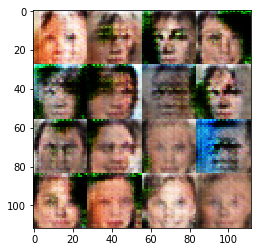

Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 1.5509
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.4411
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 1.4881
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 1.2247
Epoch 1/1.

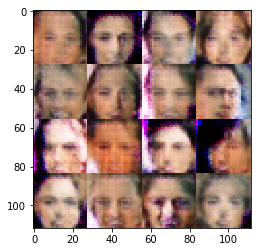

Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.3408
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 1.2399
Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 1.7137
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 2.0226
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 1.1482
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.3853
Epoch 1/1.

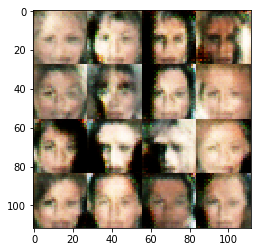

Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.7835... Generator Loss: 0.2896
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 2.4581
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 1.6707
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.3195
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 1.5673
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.7706... Generator Loss: 0.3143
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 1.4122
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.0767
Epoch 1/1.

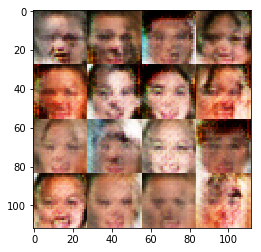

Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 1.7264
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 1.4884
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.1897
Epoch 1/1.

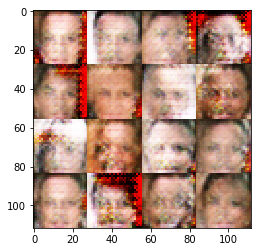

Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.2665
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 1.2436
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 1.1567
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.3368
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.6750
Epoch 1/1.

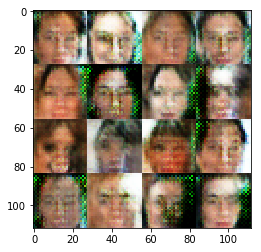

Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 1.5796
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 2.6867
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 1.7679... Generator Loss: 0.3047
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 1.1793
Epoch 1/1.

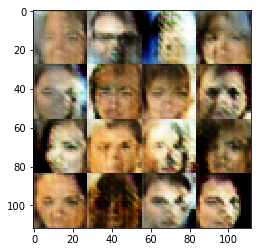

Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.6920
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.4869
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 1.1764
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 2.0147... Generator Loss: 2.2268
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.3929
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.3805
Epoch 1/1.

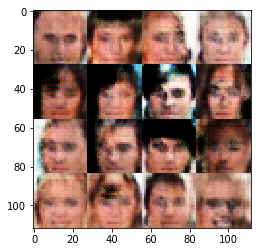

Epoch 1/1... Discriminator Loss: 1.8037... Generator Loss: 2.5066
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.6105... Generator Loss: 0.3829
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.1913
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.5035
Epoch 1/1.

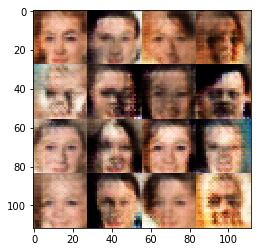

Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 2.2670
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.4053
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 1.0513
Epoch 1/1.

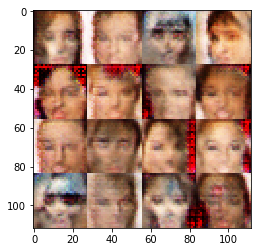

Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.9184
Epoch 1/1.

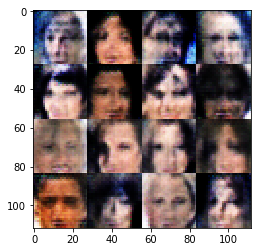

Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.2631
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 2.0349
Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 0.6502
Epoch 1/1.

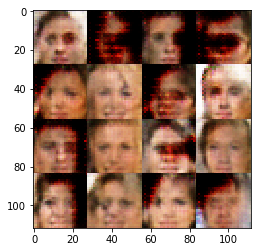

Epoch 1/1... Discriminator Loss: 2.2785... Generator Loss: 3.0210
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.9333
Epoch 1/1.

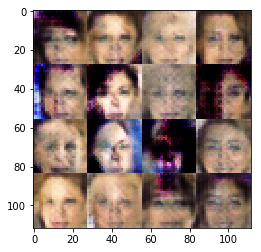

Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 1.1635
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 1.6271
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.2288
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 2.2986... Generator Loss: 0.1515
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.7905... Generator Loss: 1.8759
Epoch 1/1... Discriminator Loss: 1.8042... Generator Loss: 0.3495
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 1.1347
Epoch 1/1.

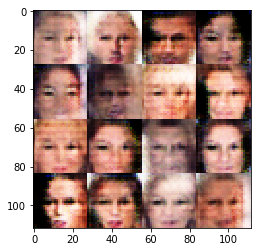

Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 0.8345
Epoch 1/1.

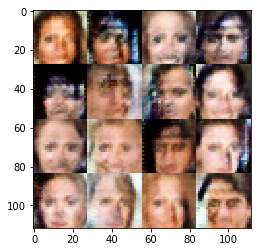

Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.1903
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 1.2407
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 2.1732
Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 0.7996... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 1.0130
Epoch 1/1.

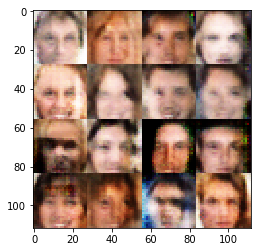

Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.4216
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 1.3231
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 1.5576
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.4472
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.8922
Epoch 1/1.

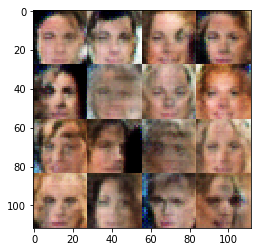

Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 1.7312
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.3921
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 1.6922
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 1.5873... Generator Loss: 0.3599
Epoch 1/1... Discriminator Loss: 1.8327... Generator Loss: 0.3334
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 1.8785
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.4210
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 1.0738
Epoch 1/1.

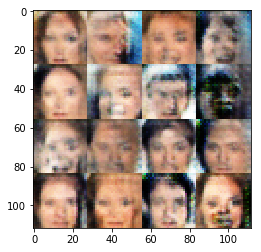

Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.6059


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.